In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches

In [15]:
class NeuralNetwork():
    def __init__(self):
        self.layers = []
        self.cache = {}
        self.num_layers = -1
        self.dense_layers = []
    def set_layers(self):
        """
        Once an architecture is set in self.layers, run this function for needed initialization
        """
        i = 0
        for j in self.layers:
            if not callable(j):
                self.dense_layers.append(j)
                i += 1
        self.num_layers = i
    def dense_layer(self,n_inputs,n_neurons):
        """
        Used to create a dense(or hidden layer)
        Returns: a list of length 2, the weights of the layer are randomly initialized using a uniform
        distribution and the bias is initialied to the zero vector
        """
        w = np.random.rand(n_inputs,n_neurons)
        b = np.zeros((n_neurons,1))
        return [w,b]
    def forward(self,X):
        """
        Uses model parameters and an input X to compute the model output
        """
        num_A = 1
        num_Z = 1
        for a,i in enumerate(self.layers):
            if callable(i):
                X = i(X)
                self.cache[f"A{num_A}"] = X
                num_A += 1
            else:
                self.cache[f"W{num_Z}"] = i[0]
                X = i[0].T.dot(X) + i[1]
                self.cache[f"Z{num_Z}"] = X
                num_Z += 1
        return X
    def back_propagation(self,X,y_pred,y):
        """
        Takes model input, the model prediction from the forward step, and the correct output.
        Backpropagates the error along the network to compute partial derivative terms
        Stores all output in self.cache
        """
        m = y.shape[1]
        cache = self.cache
        num_layers = self.num_layers
        dZ = y_pred - y #This is the derivative of the cross-entropy loss function
        cache[f"dZ{num_layers}"] = dZ
        cache[f"dW{num_layers}"] = (1/m) * dZ.dot(cache[f"A{num_layers - 1}"].T)
        cache[f"db{num_layers}"] = (1/m) * np.sum(dZ,axis = 1,keepdims=True)
        cache[f"dA{num_layers - 1}"] = cache[f"W{num_layers}"].dot(dZ)
        for i in range(num_layers-1,0,-1):
            dZ = cache[f"dA{i}"] 
            cache[f"dZ{i}"] = dZ * self.ReLU_Derivative(cache[f"Z{i}"]) #Change to work with any activation function
            if i > 1:
                cache[f"dW{i}"] = (1/m) * dZ.dot(cache[f"A{i - 1}"].T)
            else:
                cache[f"dW{i}"] = (1/m) * dZ.dot(X.T)
            cache[f"db{i}"] = (1/m) * np.sum(dZ,axis = 1,keepdims=True)
            cache[f"dA{i - 1}"] = cache[f"W{i}"].dot(dZ)
    def ReLU(self,X):
        """
        Rectified Linear Unit:
        Takes X: which can either be a real number of a vector:
        Returns X if X is greater than 0, otherwise returns 0
        """
        return np.maximum(0,X)
    def ReLU_Derivative(self,X):
        temp = np.copy(X)
        temp[temp<=0] = 0
        temp[temp>0] = 1
        return temp
    def softmax(self,x):
        """
        Softmax function stabilized
        """
        return(np.exp(x-np.max(x)) / np.exp(x-np.max(x)).sum())
    def softmax_derivative(x):
        """
        Derivative of the softmax function for backpropagation
        """
        s = softmax(x)
        s_diag = np.diagflat(s)
        return s_diag - np.dot(s, s.T)
    def cross_entropy_loss(self,y,y_pred):
        y_pred = np.clip(y_pred, 1e-9, 1- 1e-9)
        return -np.sum(y * np.log(y_pred))
    def train(self,X,y,epochs,lr,batch_size = None):
        """
        Trains the model over a given number of epochs with a specified learning rate.
        """
        losses = []
        slices = None
        
        if batch_size == None:
            slices = np.arange(len(X))
        else:
            slices = gen_batches(len(X),batch_size)
        for epoch in range(epochs):
            num_correct = 0
            for p,j in enumerate(slices):
                training_ex = X[j]
                if batch_size != None:
                    training_ex = training_ex.reshape(training_ex.shape[1],batch_size)
                #Forward pass - compute output
                y_pred = self.forward(training_ex)
                if np.argmax(y_pred) == np.argmax(y[j]):
                    num_correct += 1
                accuracy = num_correct / (p+1)
                if batch_size == None:
                    if p % 10000 == 0:
                        print(f"Epoch {epoch} ======= Iteration {p}=======Accuracy Rate{accuracy}")
                else:
                    pass
                losses.append(accuracy)
                if np.isnan(y_pred).any():
                    print(f'Iteration{p} NAN ERROR====Training Terminated')
                    return
                #Backward pass - compute gradients
                self.back_propagation(training_ex,y_pred,y[p])
                #Gradient Descent- update weights
                for k in range(len(self.dense_layers)):
                   # print(self.layers[k][0].shape,self.cache[f"dW{k+1}"].shape)
                    self.dense_layers[k][0] -= lr * self.cache[f"dW{k+1}"].T
                    self.dense_layers[k][1] -= lr * self.cache[f"db{k+1}"]
        return losses

In [16]:
def plot_pic(df,i):
    plt.imshow(df.iloc[i,1:].to_numpy().reshape(28,28),cmap='gray')

In [17]:
#Data Preprocessing
df = pd.read_csv('mnist_data/mnist_train.csv')

In [18]:
X = df.iloc[:,1:].to_numpy()
y = df.iloc[:,0].to_numpy()
# #normalize X_data
for i,a in enumerate(X):
    X[i] = (a - np.mean(a))/(np.std(a))
new_y = []
for i in range(len(y)):
    temp = np.zeros((10,1))
    temp[y[i]] = 1
    new_y.append(temp)
new_y = np.array(new_y)
X_train,X_test,y_train,y_test = train_test_split(X,new_y,test_size=.3)
X_train = X_train.reshape(42000, 784,1)
X_test = X_test.reshape(X_test.shape[0], 784,1)

In [37]:
nn = NeuralNetwork()
l1 = nn.dense_layer(784,100)
l2 = nn.dense_layer(100,10)

In [38]:
nn.layers = [l1,nn.ReLU,l2,nn.softmax]
nn.set_layers()

In [39]:
losses = nn.train(X_train,y_train,epochs = 2, lr = 0.001,batch_size=None)

Epoch 0 ======= Iteration 0=======Accuracy Rate0.0
Epoch 0 ======= Iteration 10000=======Accuracy Rate0.5778422157784222
Epoch 0 ======= Iteration 20000=======Accuracy Rate0.6940152992350382
Epoch 0 ======= Iteration 30000=======Accuracy Rate0.7439752008266391
Epoch 0 ======= Iteration 40000=======Accuracy Rate0.7741556461088472
Epoch 1 ======= Iteration 0=======Accuracy Rate1.0
Epoch 1 ======= Iteration 10000=======Accuracy Rate0.8791120887911209
Epoch 1 ======= Iteration 20000=======Accuracy Rate0.8767061646917654
Epoch 1 ======= Iteration 30000=======Accuracy Rate0.8762374587513749
Epoch 1 ======= Iteration 40000=======Accuracy Rate0.8776280592985175


In [117]:
num_correct = 0
for i in range(len(X_test)):
    if np.argmax(nn.forward(X_test[i])) == np.argmax(y_test[i]):
        num_correct += 1

In [118]:
print(f"Total Accuracy: {num_correct/len(X_test)}")

Total Accuracy: 0.8811666666666667


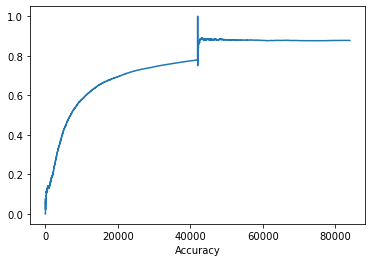

In [114]:
#Plotting accuracy
plt.plot(losses)
plt.xlabel("Training iteration")
plt.xlabel("Accuracy")
plt.show()

In [124]:
#Print model output for the 100th testing example
print(np.argmax(nn.forward(X_test[100]),axis = 0))

[5]


In [125]:
#Print correct output fot the 100th testing example
print(np.argmax(y_test[100],axis = 0))

[5]
